In [1]:
#https://cloud.google.com/bigquery/docs/best-practices-costs

In [2]:
from google.cloud import bigquery

# Anomaly Detection in Blockchain System
1. This work is aimed to enhance the working of blockchain system by automatically recognizing and filtering out anomalous activities. The targeted components of blockchain architecture are Block and Transaction for the given task. Since they are the most basic and vital aspects in the working of blockchain systems.
1. 
1. What is Anomaly Detection?
1. Anomaly detection is a technique used to identify unusual patterns that do not conform to expected behavior, called outliers. It has many applications in business, health monitoring, network traffic systems, etc.
1. 
1. What is the Blockchain System?
1. “A blockchain is a time-stamped series of an immutable record of data that is managed by a cluster of computers not owned by any single entity. Each of these blocks of data is secured and bound to each other using cryptographic principles”. In simple terms, blockchain is a chain of blocks; the words “block” and “chain” are the digital information and public database, respectively. The core components of blockchain architecture:
1. 
1. Node — user or computer within the blockchain
1. Transaction — smallest building block of a blockchain system
1. Block — a data structure used for keeping a set of transactions which is distributed to all nodes in the network
1. Chain — a sequence of blocks in a specific order
1. Miners — specific nodes which perform the block verification process
1. Consensus— a set of rules and arrangements to carry out blockchain operations
1. More information about blockchain can be found at (https://blockgeeks.com/guides/what-is-blockchain-technology/ https://www.investopedia.com/terms/b/blockchain.asp).
1. 
1. This kernel organization can be described as:
1. 
1. Importing Essential Libraries
1. Reading and Processing data
1. Model Building & Evaluation
1. Isolation Forest Algorithm
1. K Means Algorithm
1. Conclusion**

In [3]:
from google.cloud import bigquery
from scipy.stats.mstats import zscore
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib as mpl
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest 
import seaborn as sns
import datetime as dt
from datetime import datetime,tzinfo
import scipy, json, csv, time, pytz
from pytz import timezone
import numpy as np
import pandas as pd
seed = 135
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [4]:
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [5]:
# The query to get date, number of transactions from Google BigQuery bitcoin blockchain dataset 
# Select records from the last three years and group them with respect to date
query_1 = """
SELECT 
   DATE(TIMESTAMP_MILLIS(timestamp)) AS Date,
   COUNT(transactions) AS Transactions
FROM `bigquery-public-data.bitcoin_blockchain.blocks`
GROUP BY date
HAVING date >= '2016-01-01' AND date <= '2018-08-30'
ORDER BY date
"""
query_job_1 = client.query(query_1)
# Waits for the query to finish
iterator_1 = query_job_1.result(timeout=30)
rows_1 = list(iterator_1)
df_1 = pd.DataFrame(data=[list(x.values()) for x in rows_1], columns=list(rows_1[0].keys()))

In [6]:
# The query to get sum of all satoshis spent each day and number of blocks
query_2 = """
SELECT
  o.Date,
  COUNT(o.block) AS Blocks,
  SUM(o.output_price) AS Output_Satoshis
FROM (
  SELECT
    DATE(TIMESTAMP_MILLIS(timestamp)) AS Date,
    output.output_satoshis AS output_price,
    block_id AS block
  FROM
    `bigquery-public-data.bitcoin_blockchain.transactions`,
    UNNEST(outputs) AS output ) AS o
GROUP BY
  o.date
HAVING o.date >= '2016-01-01' AND date <= '2018-08-30'
ORDER BY o.date, blocks
"""
query_job_2 = client.query(query_2)
# Waits for the query to finish
iterator_2 = query_job_2.result(timeout=30)
rows_2 = list(iterator_2)
df_2 = pd.DataFrame(data=[list(x.values()) for x in rows_2], columns=list(rows_2[0].keys()))

df_2["Output_Satoshis"]= df_2["Output_Satoshis"].apply(lambda x: float(x/100000000))

In [7]:
df_1.head()

,Date,Transactions
0,2016-01-01,135
1,2016-01-02,145
2,2016-01-03,145
3,2016-01-04,181
4,2016-01-05,157


In [8]:
df_2.head()

,Date,Blocks,Output_Satoshis
0,2016-01-01,361519,9.574813e+05
1,2016-01-02,455120,1.037920e+06
2,2016-01-03,478708,8.985480e+05
3,2016-01-04,492865,1.067068e+06
4,2016-01-05,506371,1.392599e+06


In [9]:
# merge the two dataframes
result = pd.merge(df_1,
                 df_2[['Date', 'Blocks', 'Output_Satoshis']],
                 on='Date')
result.head()

,Date,Transactions,Blocks,Output_Satoshis
0,2016-01-01,135,361519,9.574813e+05
1,2016-01-02,145,455120,1.037920e+06
2,2016-01-03,145,478708,8.985480e+05
3,2016-01-04,181,492865,1.067068e+06
4,2016-01-05,157,506371,1.392599e+06


In [10]:
# Number of records 
len(result)

973

In [11]:
# get the overview of our data
result.describe()

,Transactions,Blocks,Output_Satoshis
count,973.000000,9.730000e+02,9.730000e+02
mean,151.965057,6.368701e+05,2.363024e+06
std,16.867214,1.363318e+05,2.747834e+06
min,2.000000,1.548900e+04,1.922581e+04
25%,142.000000,5.477540e+05,1.430821e+06
50%,152.000000,6.073870e+05,2.011497e+06
75%,163.000000,7.026960e+05,2.630808e+06
max,200.000000,1.264802e+06,6.735430e+07


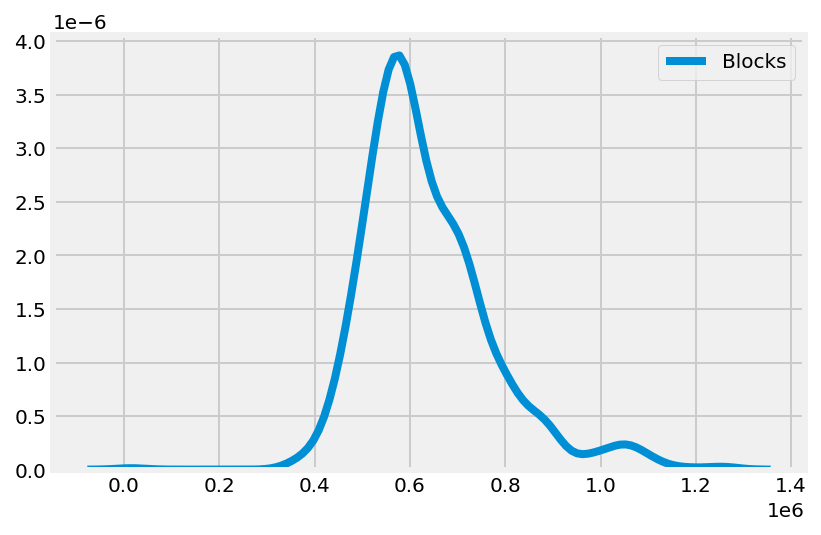

In [12]:
sns.kdeplot(result['Blocks'])

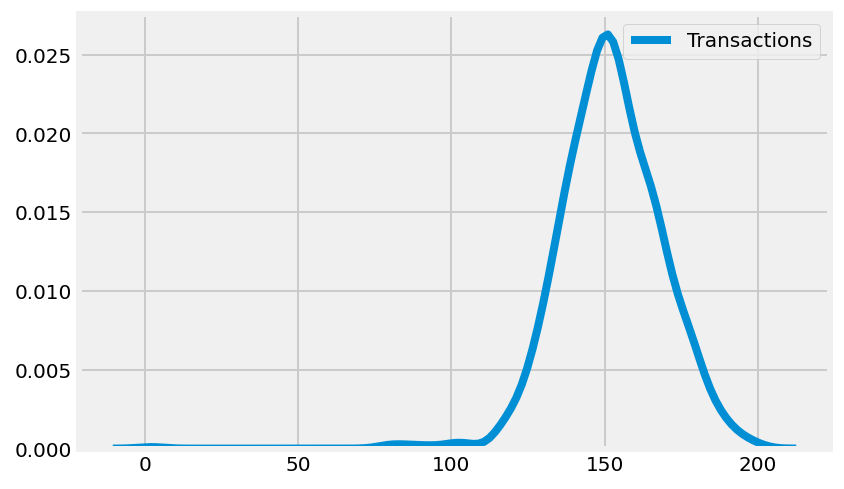

In [13]:
sns.kdeplot(result['Transactions'])

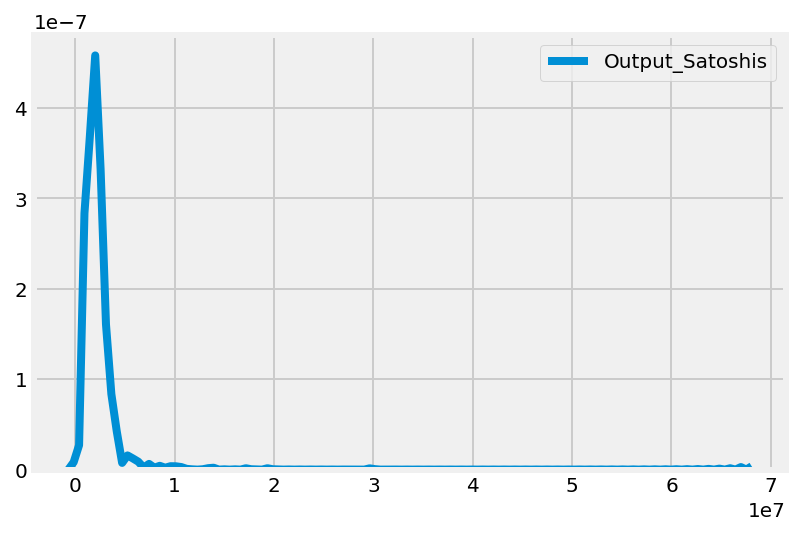

In [14]:

sns.kdeplot(result['Output_Satoshis'])

Great, mostly the features of data are following the bell-shaped curve. Now, let's plot the curves of three vital features (Transactions, Blocks, Output Satoshis) of our data with respect to the date. Is there some trend in these plots?

Text(0.5, 1.0, 'Transactions per day')

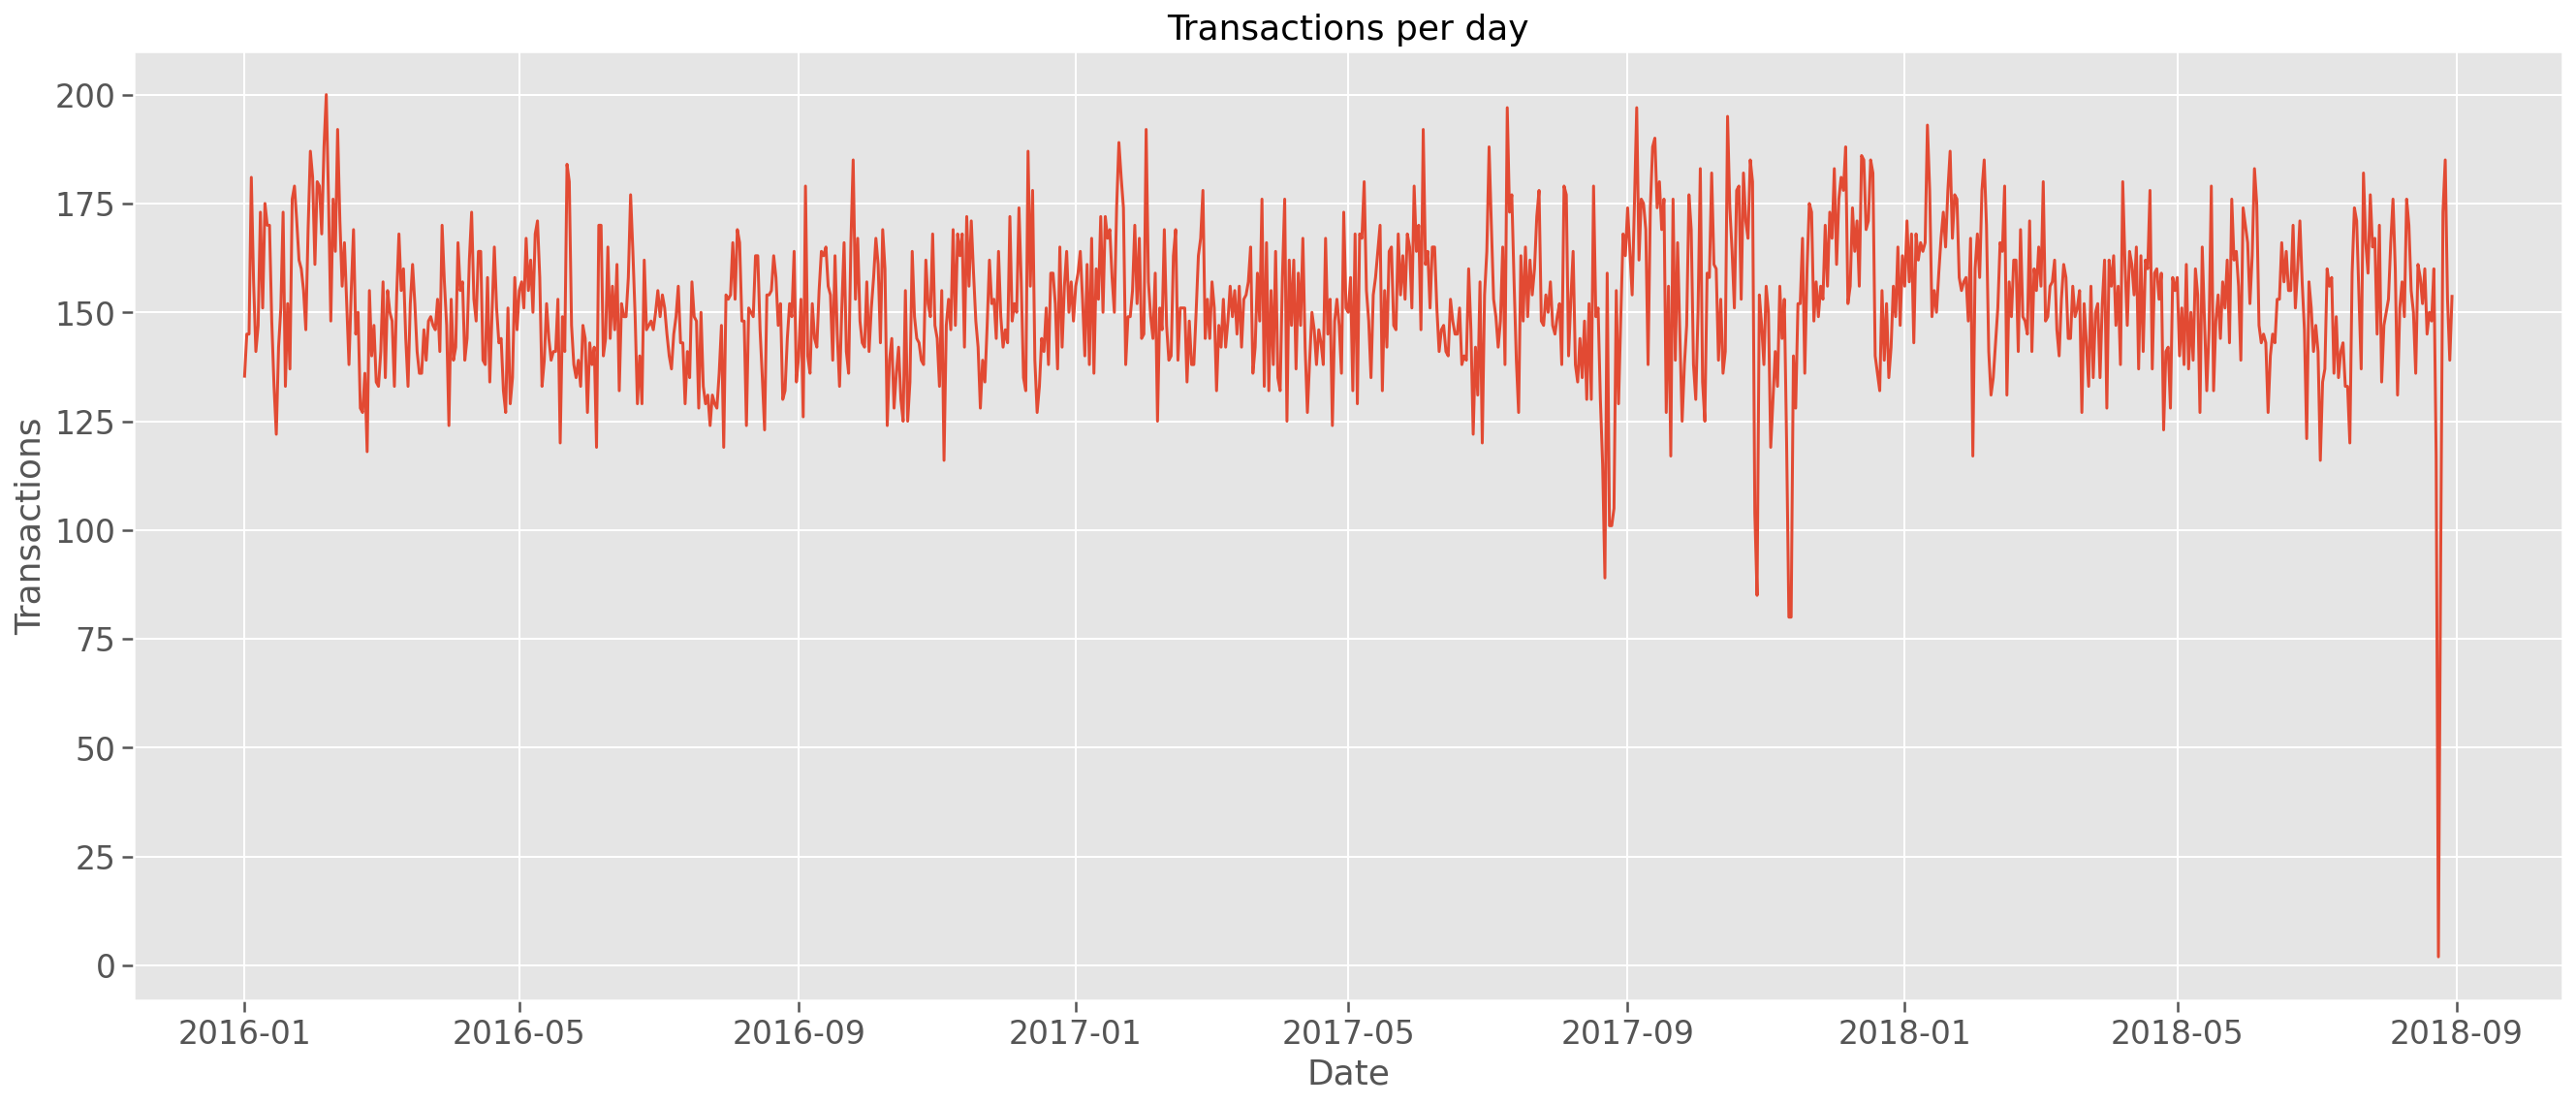

In [15]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Transactions', data=result, palette='Blues_d')
plt.title('Transactions per day')

Text(0.5, 1.0, 'Blocks per day')

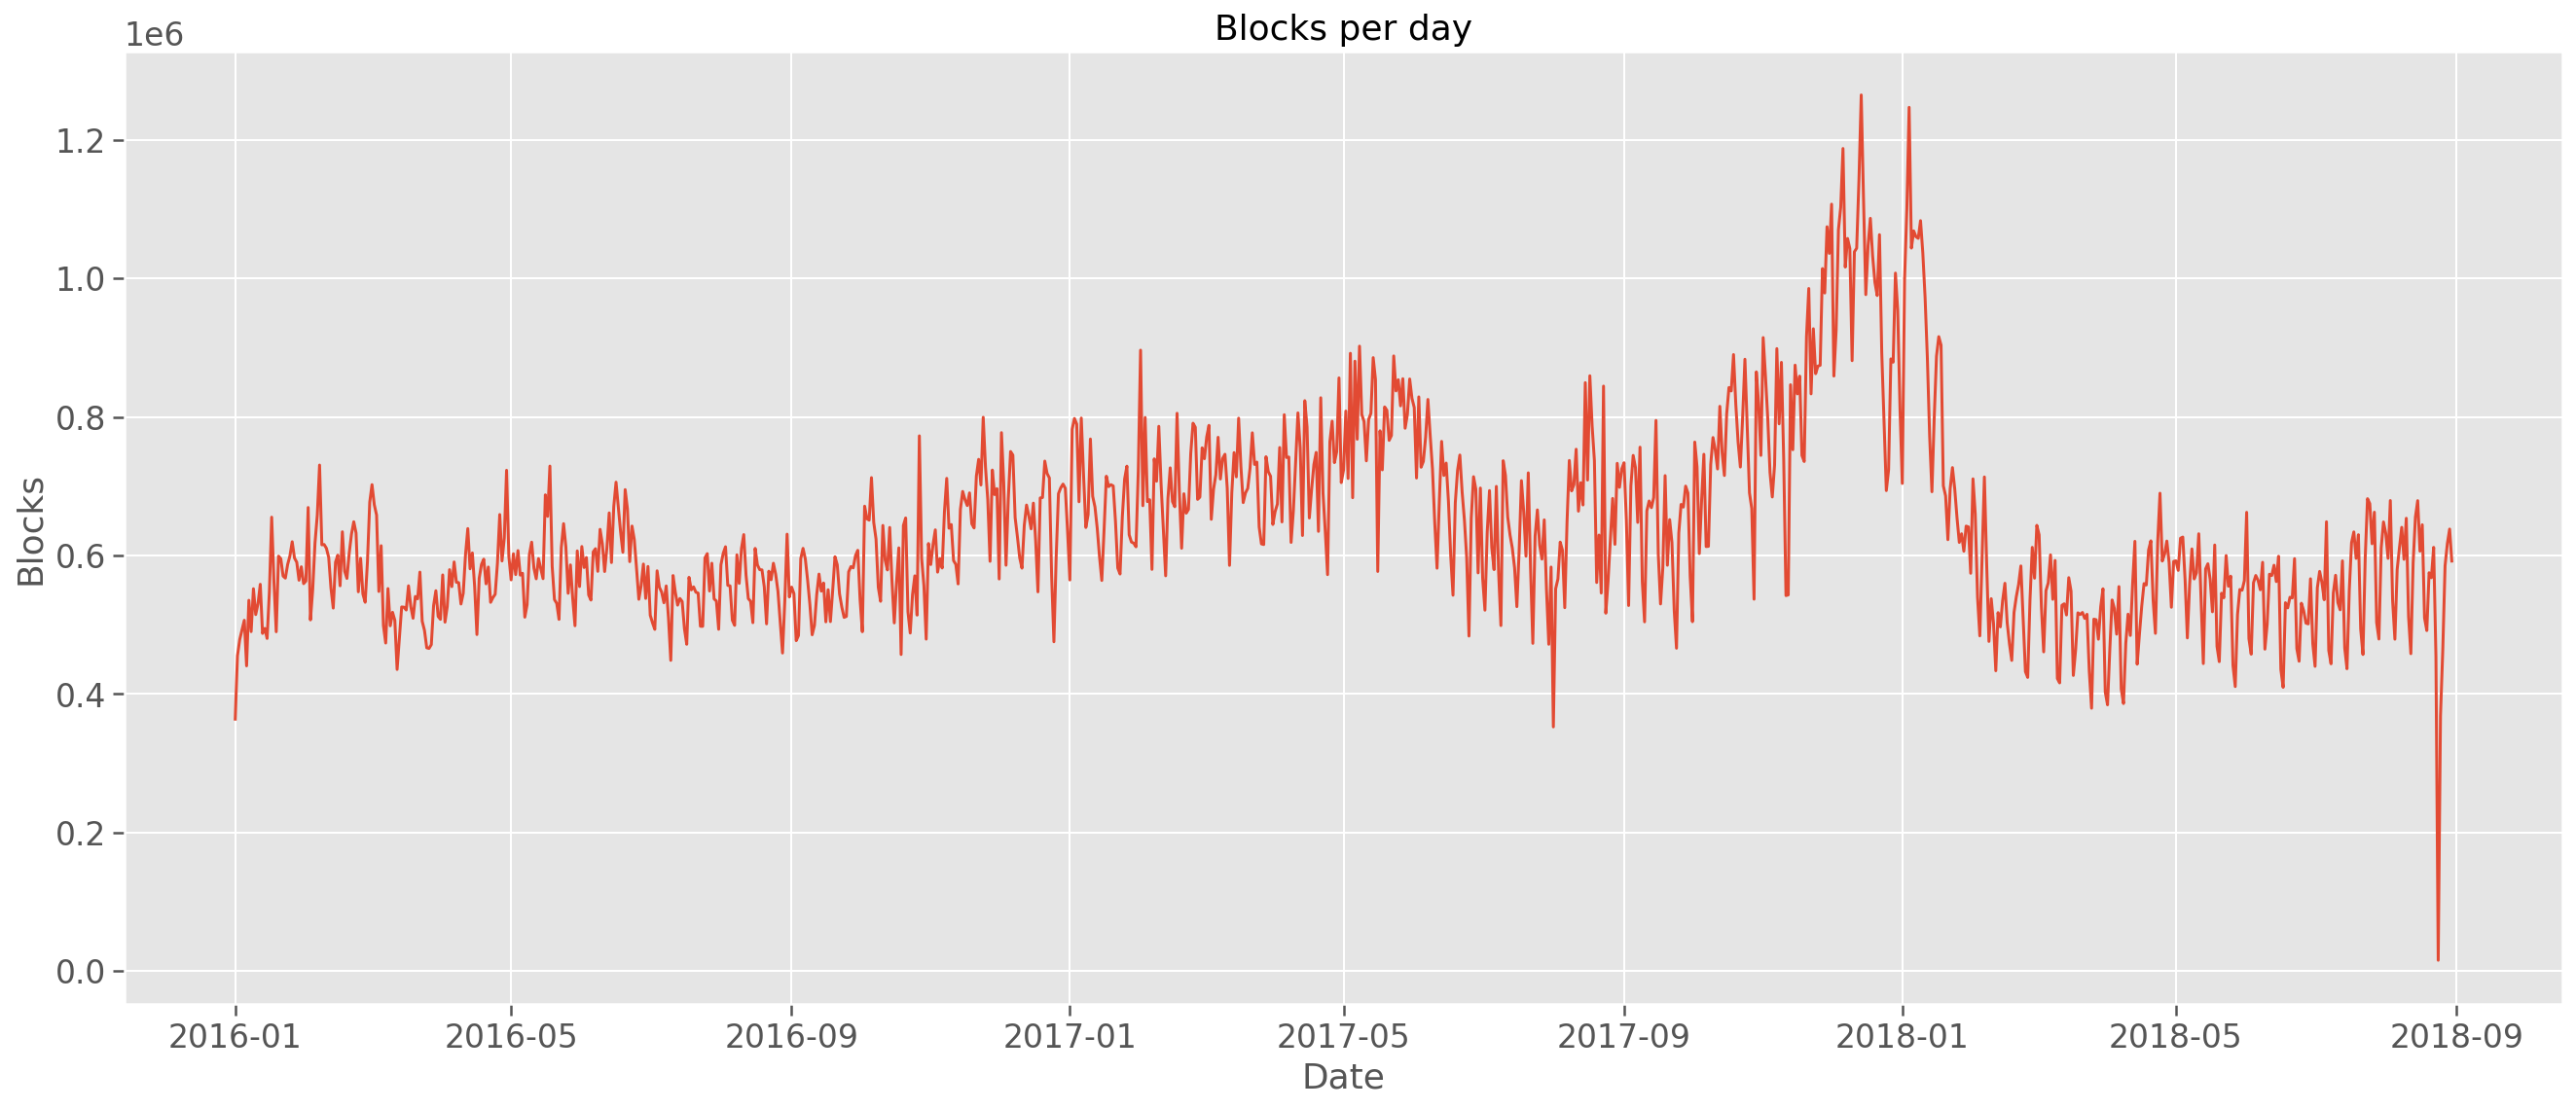

In [16]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Blocks', data=result, palette='Blues_d')
plt.title('Blocks per day')

Text(0.5, 1.0, 'Sum of all satoshis spent each day')

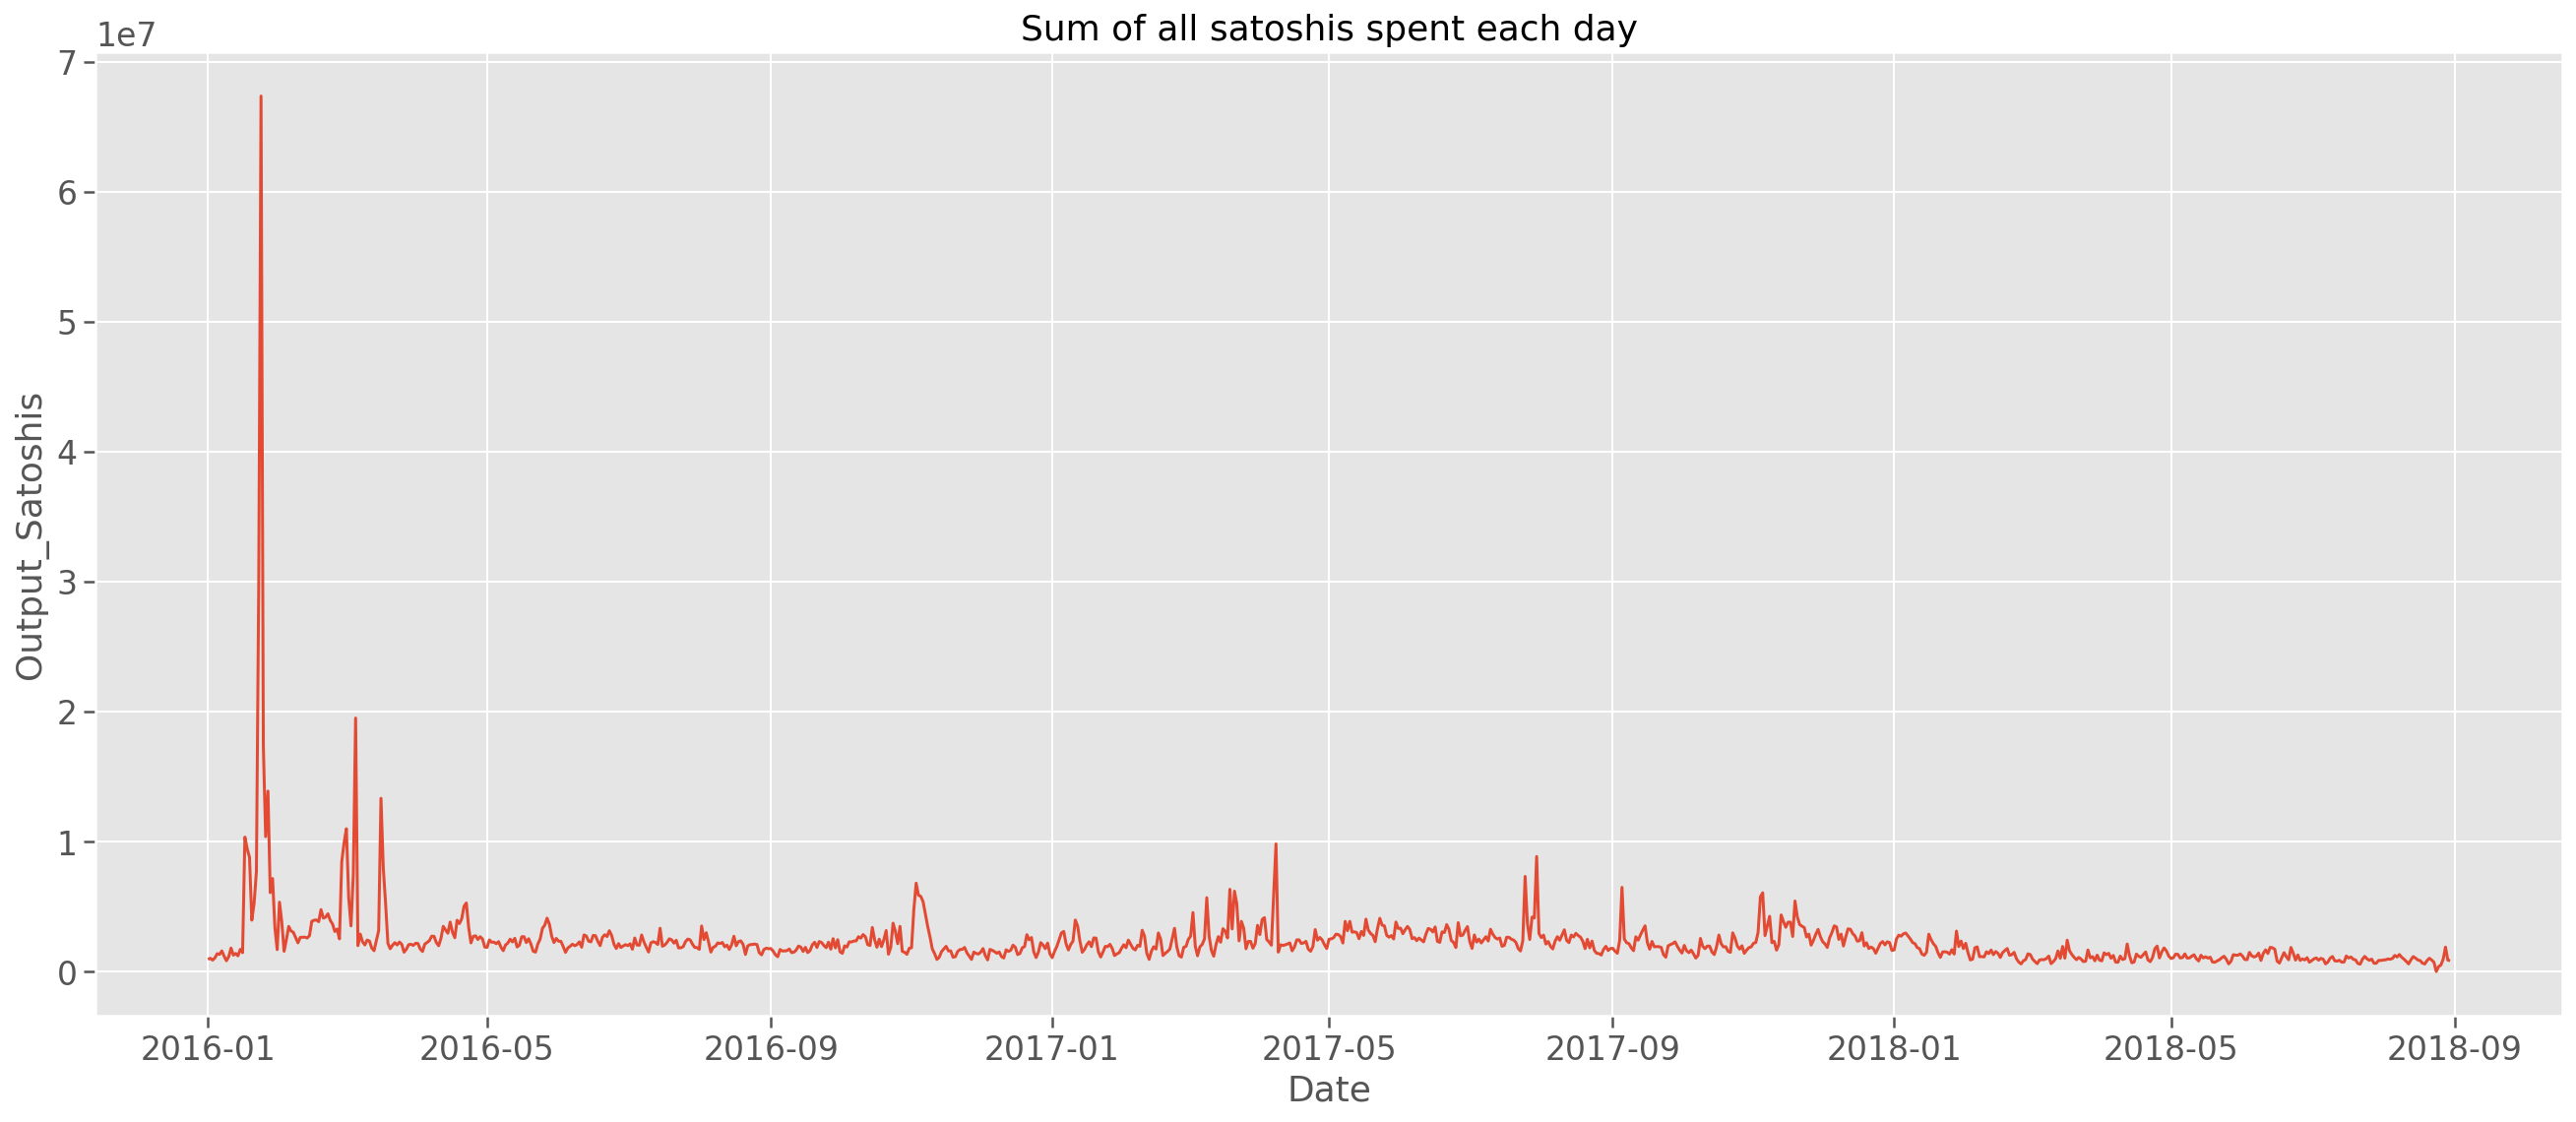

In [17]:
g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Output_Satoshis', data=result, palette='BuGn_r')
plt.title('Sum of all satoshis spent each day')

So we should now get back to the previous question. Is there some trend here in the graphs? The possible answer can be not exactly. So why did we plot those curves? Often, In anomaly detection, we make use of different algorithms to determine the anomalies in the data. Mostly unsupervised learning-based anomaly detection algorithm uses outliers to detect anomalies. Yes, we will evaluate these outliers employing several anomaly detection algorithms in this notebook and will get back to these curves again at last to determine the anomalies.

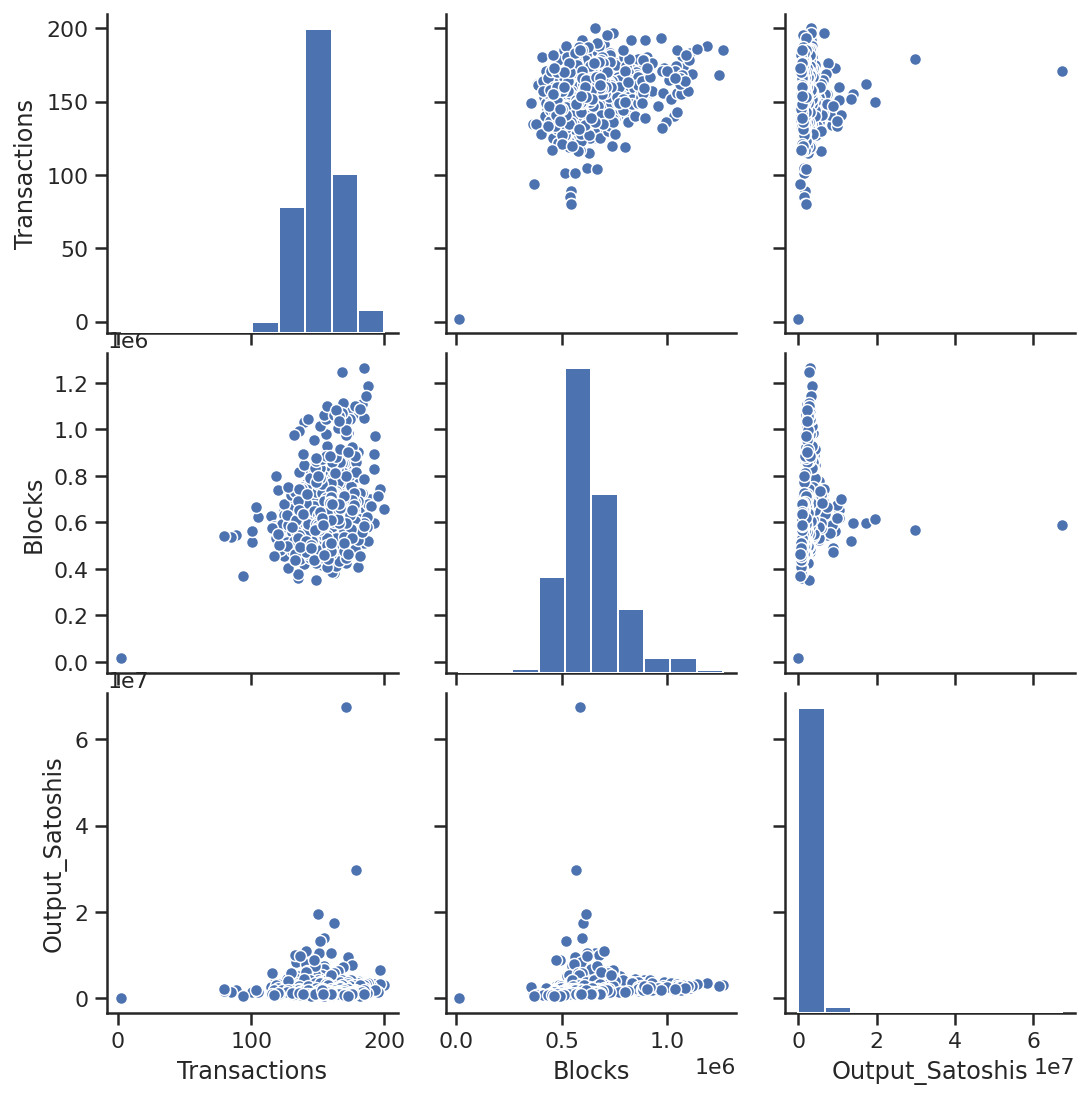

In [18]:
# check the relation among the features of data
sns.set(style="ticks")
sns.pairplot(result)

In [19]:
# select the three most important features (Transactions, Blocks, Output Satoshis) from the data
data = result[['Output_Satoshis','Blocks','Transactions']]
outliers_fraction=0.05
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.05)

Text(0.5, 0.92, 'Transactions vs Blocks vs Sum of Output Satoshis: Red represents Anomalies')

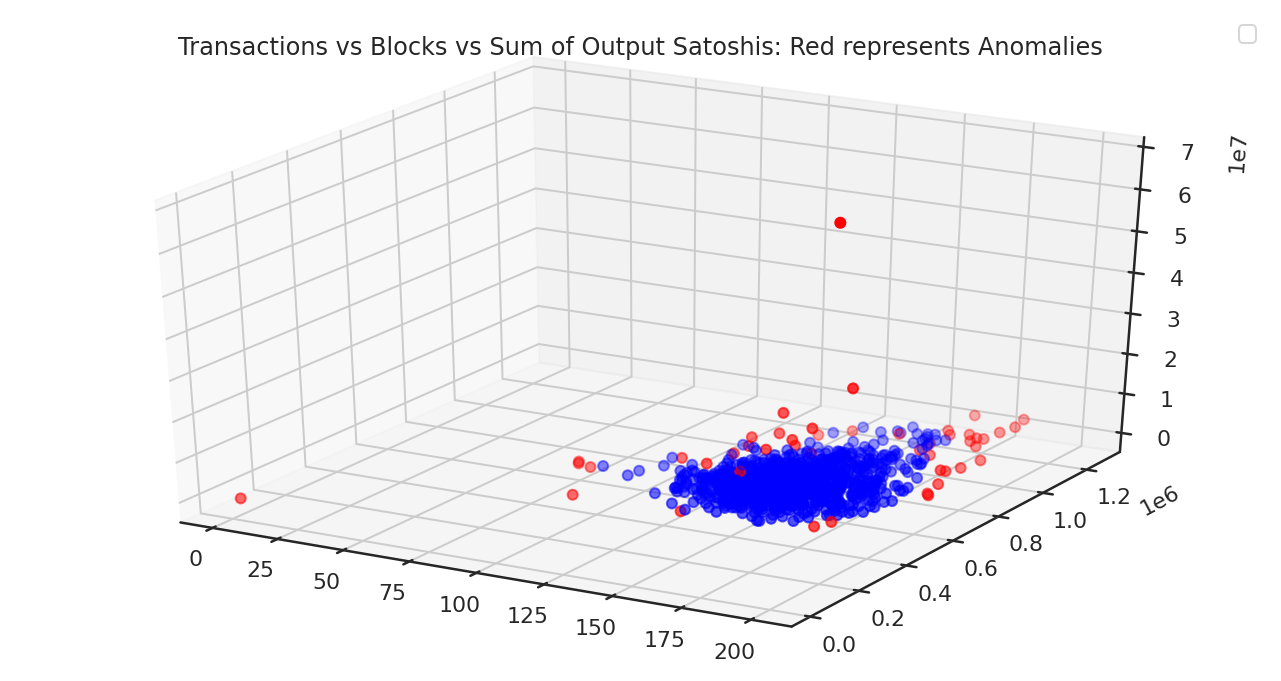

In [20]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111,projection='3d')
X = result.iloc[:,1:4].values
colors = np.array(['red', 'blue'])
y_pred = model.fit_predict(data)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=25, color=colors[(y_pred + 1) // 2] )
ax.legend()
#plt.xlabel('Transactions')
#plt.ylabel('Blocks')
#plt.zlabel('Sum of Output Satoshis')
plt.title('Transactions vs Blocks vs Sum of Output Satoshis: Red represents Anomalies')



The above plot cites Transactions, Features, Sum of Output Satoshis features to represents the anomalies in the data using the Isolation Forest method. Now, summarize the predictions just performed by assigning them binary values i.e., 0 or 1 (0 for normal, 1 for anomaly).

In [21]:
# create a new column for storing the results of Isolation Forest method
result['anomaly_IsolationForest'] = pd.Series(model.predict(data))
result['anomaly_IsolationForest'] = result['anomaly_IsolationForest'].apply(lambda x: x == -1)
result['anomaly_IsolationForest'] = result['anomaly_IsolationForest'].astype(int)
result['anomaly_IsolationForest'].value_counts()

0    924
1     49
Name: anomaly_IsolationForest, dtype: int64

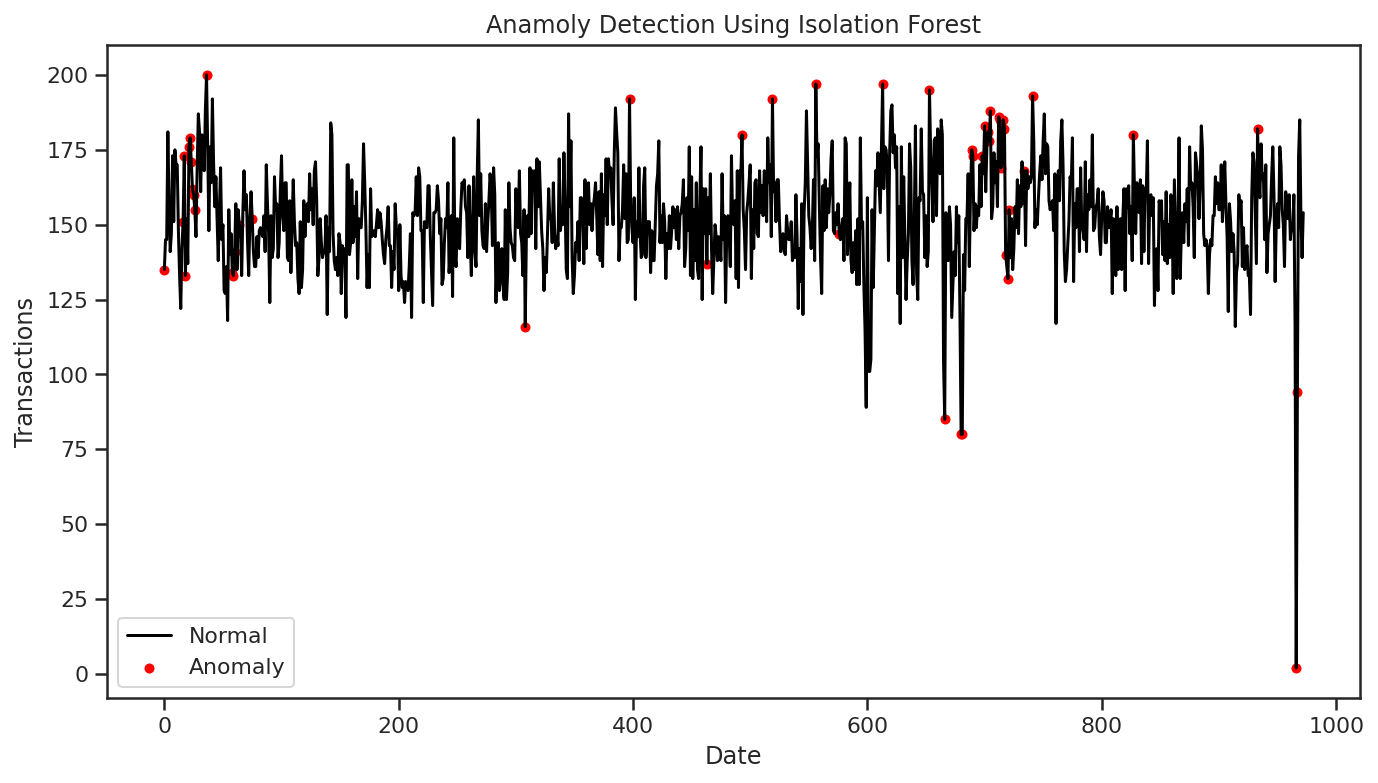

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_IsolationForest'] == 1]
ax.plot(result['Transactions'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Transactions'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Isolation Forest")
plt.xlabel('Date')
plt.ylabel('Transactions')
#plt.savefig('IsolationForest_anomaly_Transactions.png', dpi=1000)
plt.show();


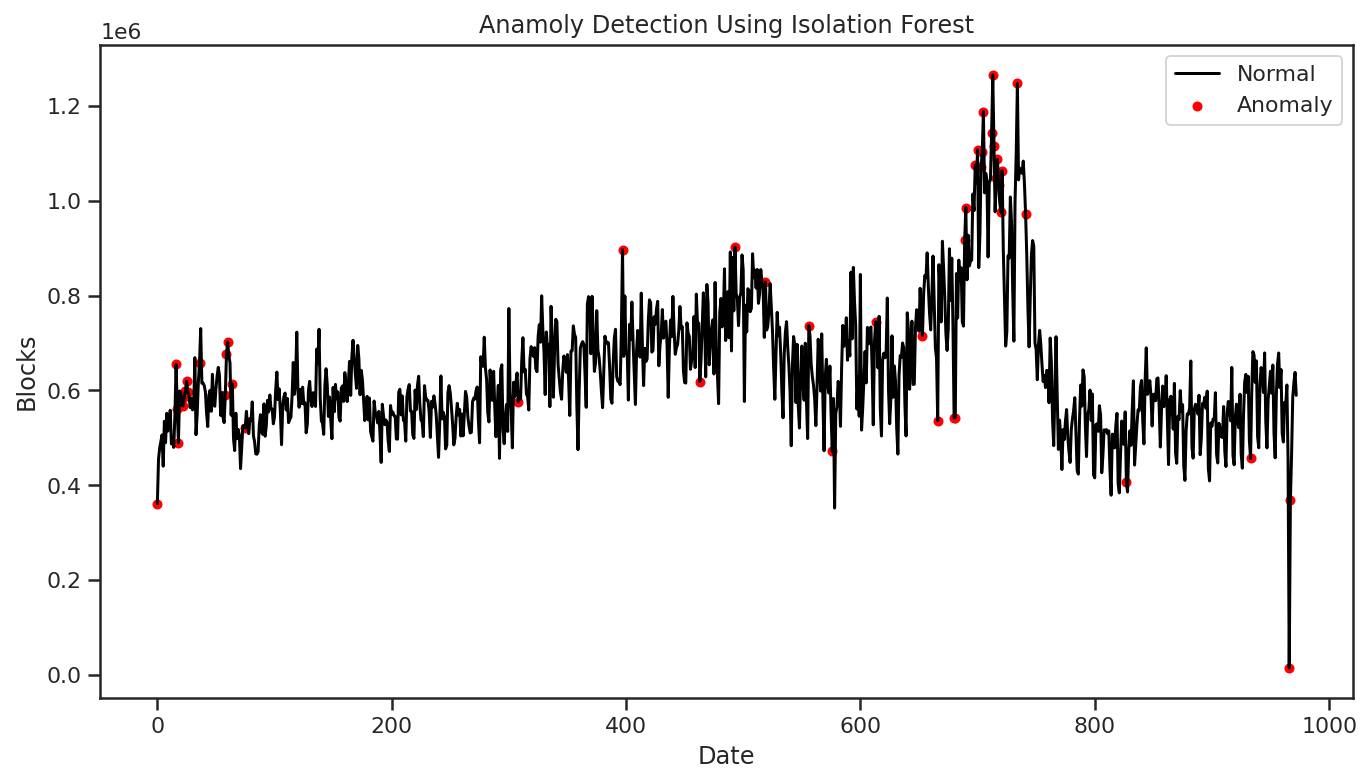

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_IsolationForest'] == 1]
ax.plot(result['Blocks'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Blocks'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Isolation Forest")
plt.xlabel('Date')
plt.ylabel('Blocks')
#plt.savefig('IsolationForest_anomaly_Blocks.png', dpi=1000)
plt.show();

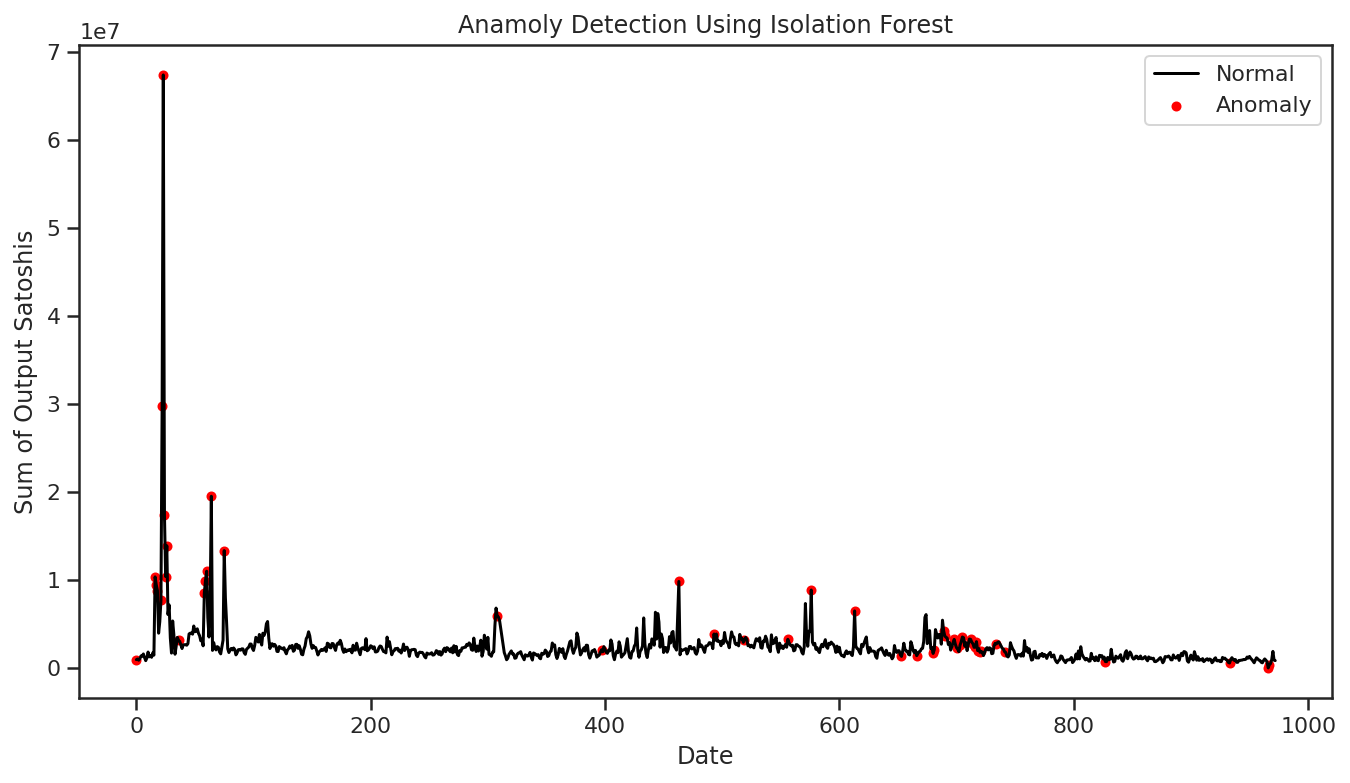

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_IsolationForest'] == 1]
ax.plot(result['Output_Satoshis'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Output_Satoshis'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Isolation Forest")
plt.xlabel('Date')
plt.ylabel('Sum of Output Satoshis')
#plt.savefig('IsolationForest_anomaly_Output_Satoshis.png', dpi=1000)
plt.show();

We just inherited use of those three previous plots (Transactions, Blocks, Output Satoshis vs. date) for better understanding the Isolation Forest method predicted anomalies by visualizing them with outliers anomaly.

In [25]:
# This code has been taken from kernel https://github.com/anish-saha/EventDetection-Paradigm01/blob/master/KMeans.ipynb

def pca_results(good_data, pca):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,10))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

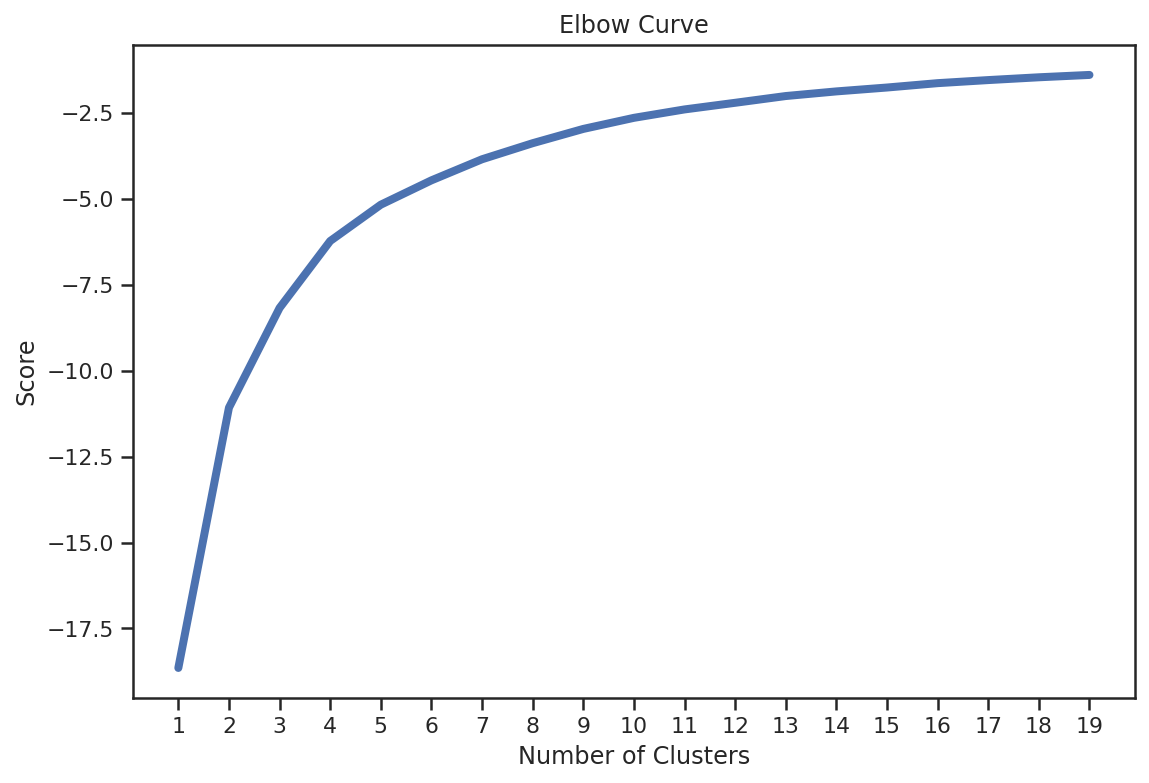

In [26]:
data_ = data.copy() # make a copy of data with three already selected features
data_ = data_.reset_index(drop=True)

data_[:] = MinMaxScaler().fit_transform(data_[:])
pca = PCA(n_components=2) # we have selected 2 components in PCA for simplicity
pca.fit(data_)
reduced_data = pca.transform(data_)
reduced_data = pd.DataFrame(reduced_data)

num_clusters = range(1, 20)

kmeans = [KMeans(n_clusters=i, random_state=seed).fit(reduced_data) for i in num_clusters]
scores = [kmeans[i].score(reduced_data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(num_clusters, scores, linewidth = 4)
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

The above elbow-curve helps to determine the number of clusters for the K-means algorithm. The most drastic change recorded in the elbow-curve at 3 or 4 or 5 number of clusters. So let's which one of them is better for our case.

,Explained Variance,0,1,2
Dimension 1,0.6341,-0.0426,-0.9062,-0.4208
Dimension 2,0.2869,0.0087,0.4208,-0.9071


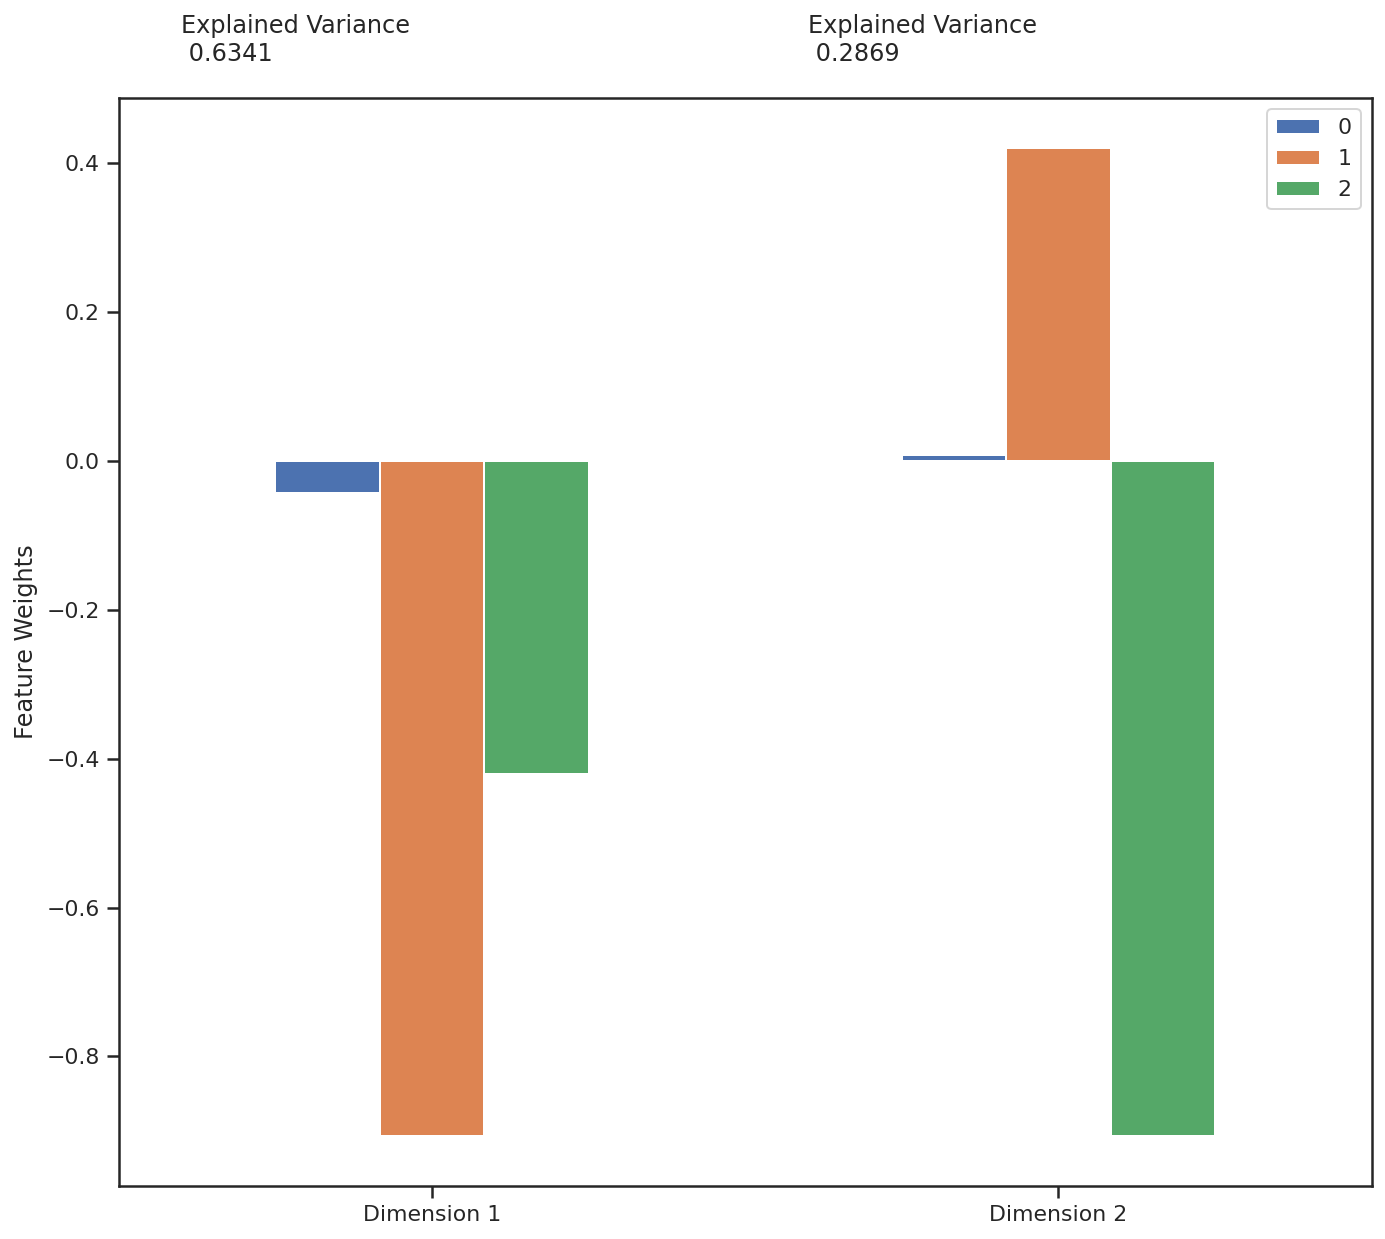

In [27]:
correlations = pd.DataFrame(data=data_).corr()
pca_results(correlations, pca)

In [28]:
#Choosing the three clusters based on the elbow curve
best_num_cluster__ = 3
km__ = KMeans(n_clusters=best_num_cluster__, random_state=seed)
km__.fit(reduced_data)
km__.predict(reduced_data)
labels__1 = km__.labels_

#Choosing the four clusters based on the elbow curve
best_num_cluster = 4
km = KMeans(n_clusters=best_num_cluster, random_state=seed)
km.fit(reduced_data)
km.predict(reduced_data)
labels = km.labels_

#Choosing the five clusters based on the elbow curve
best_num_cluster_ = 5
km_ = KMeans(n_clusters=best_num_cluster_, random_state=seed)
km_.fit(reduced_data)
km_.predict(reduced_data)
labels_1 = km_.labels_

Text(0.5, 1.0, 'Clusters based on K means: 3 clusters')

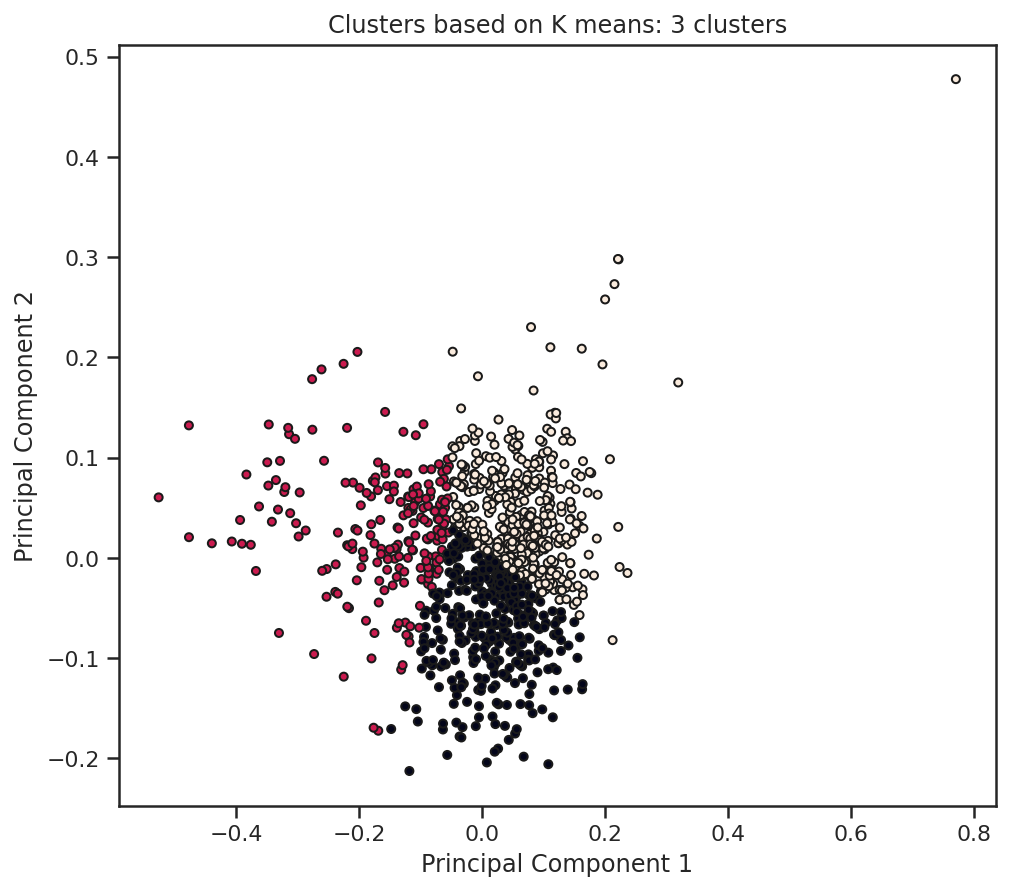

In [29]:
#Plotting based on three cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels__1.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 3 clusters')

Text(0.5, 1.0, 'Clusters based on K means: 4 clusters')

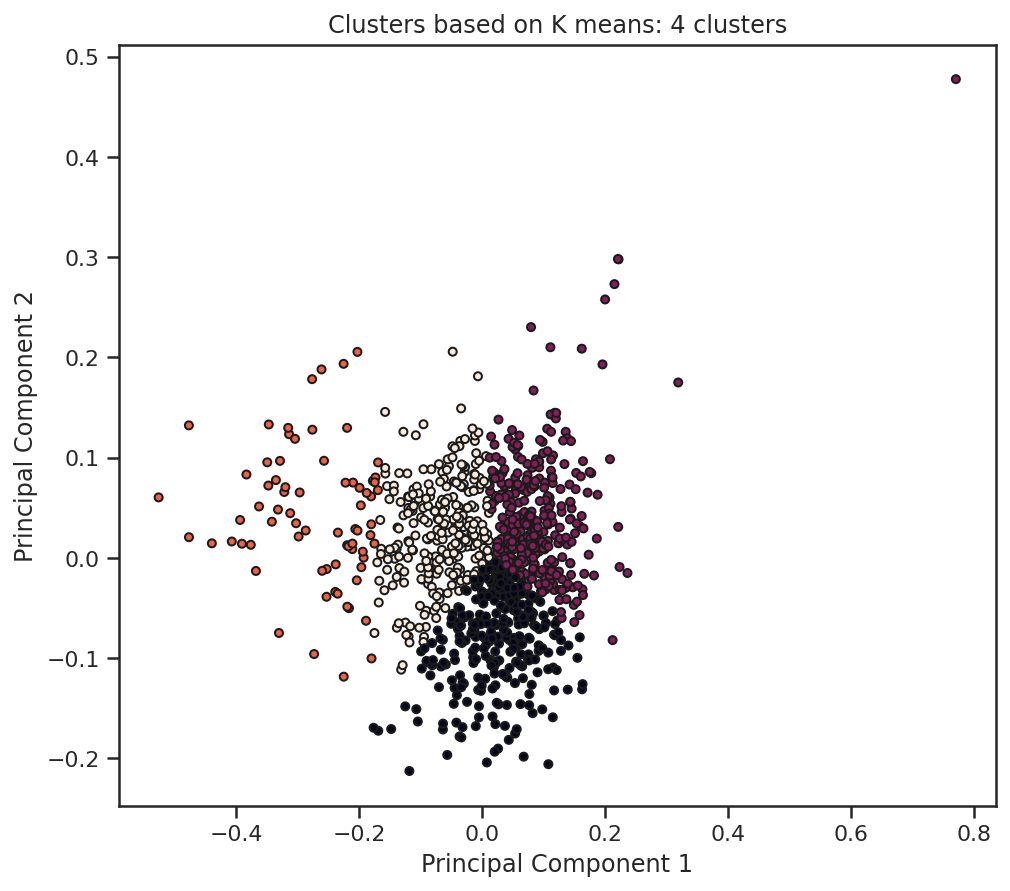

In [30]:
#Plotting based on four cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 4 clusters')

Text(0.5, 1.0, 'Clusters based on K means: 5 clusters')

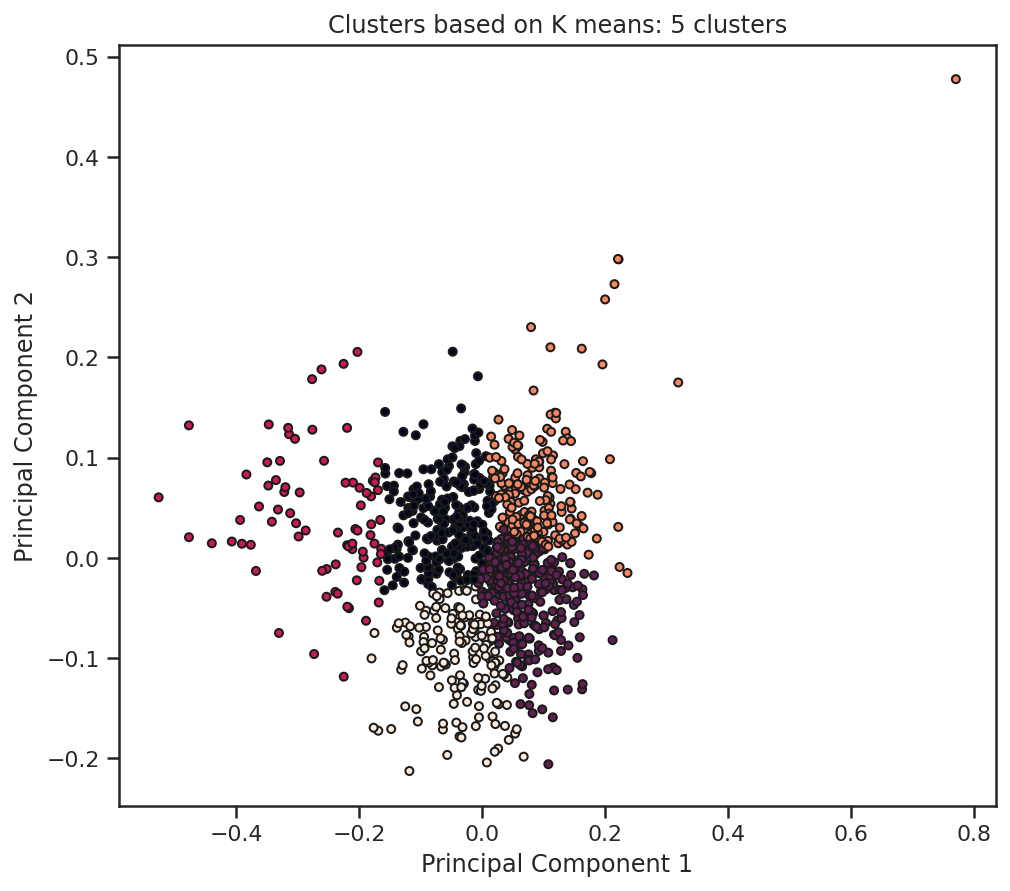

In [31]:
#Plotting based on five cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels_1.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 5 clusters')

In [32]:
reduced_data.loc[0]
mod = kmeans[best_num_cluster-1]
mod.cluster_centers_

array([[ 0.02310645, -0.08160554],
       [ 0.09258525,  0.04108875],
       [-0.27072682,  0.04217292],
       [-0.06615173,  0.02814209]])

In [33]:
reduced_data['Principal Component 1'] = reduced_data[0]
reduced_data['Principal Component 2'] = reduced_data[1]
reduced_data.drop(columns = [0, 1], inplace=True)
reduced_data.head()

,Principal Component 1,Principal Component 2
0,0.236663,-0.015200
1,0.147469,-0.029478
2,0.130448,-0.021551
3,0.043572,-0.181691
4,0.084570,-0.067146


Text(0.5, 1.0, 'Anomaly prediction using KMeans: Red represents Anomaly')

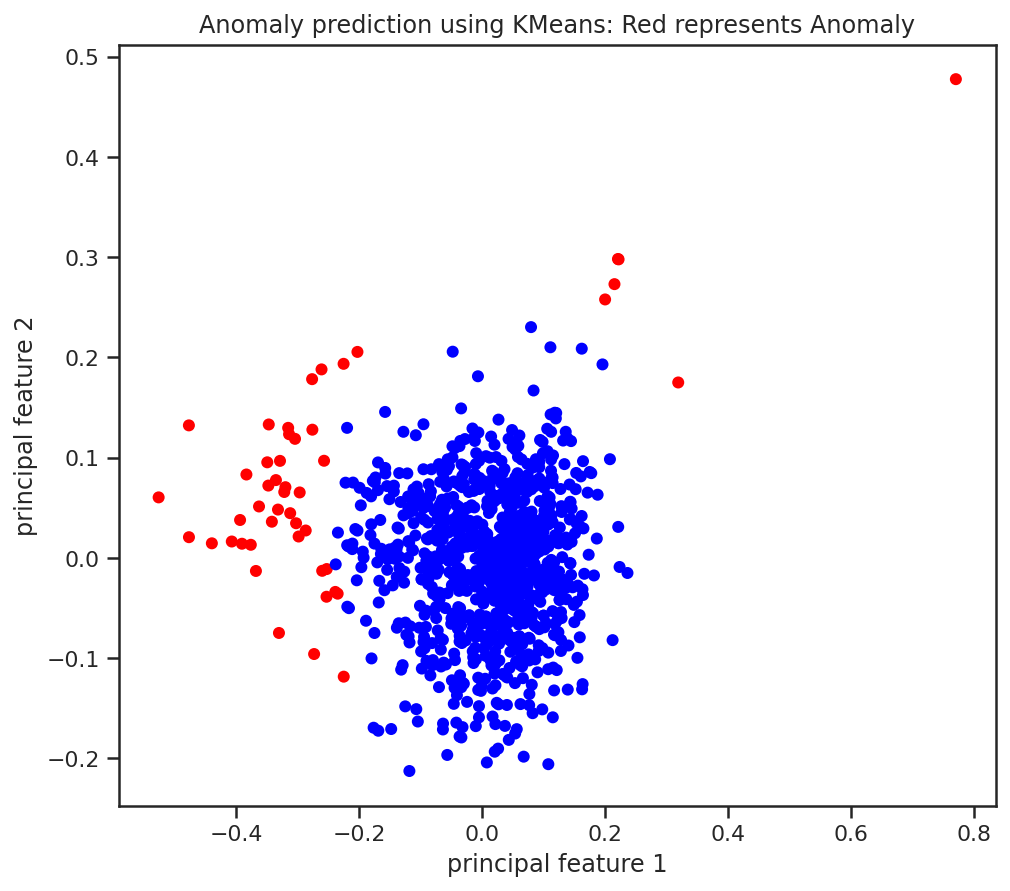

In [34]:
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.05
# find the distance between each point and its nearest centroid. The largest distances will be consdiered anomalies
distance = getDistanceByPoint(reduced_data, kmeans[best_num_cluster-1])
distance = pd.Series(distance)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()


# anomaly_kmeans contain the anomaly result of the above method  (0:normal, 1:anomaly) 
result['anomaly_kmeans'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view
#fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
#colors = {1:'#f70505', 0:'#0a48f5'}
plt.figure(figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=result["anomaly_kmeans"].apply(lambda x: colors[x]), s=25)
plt.xlabel('principal feature 1')
plt.ylabel('principal feature 2')
plt.title('Anomaly prediction using KMeans: Red represents Anomaly')
#plt.savefig('KMeans_anomaly.png', dpi=1000)

In [35]:
result['anomaly_kmeans'].value_counts()

0    925
1     48
Name: anomaly_kmeans, dtype: int64

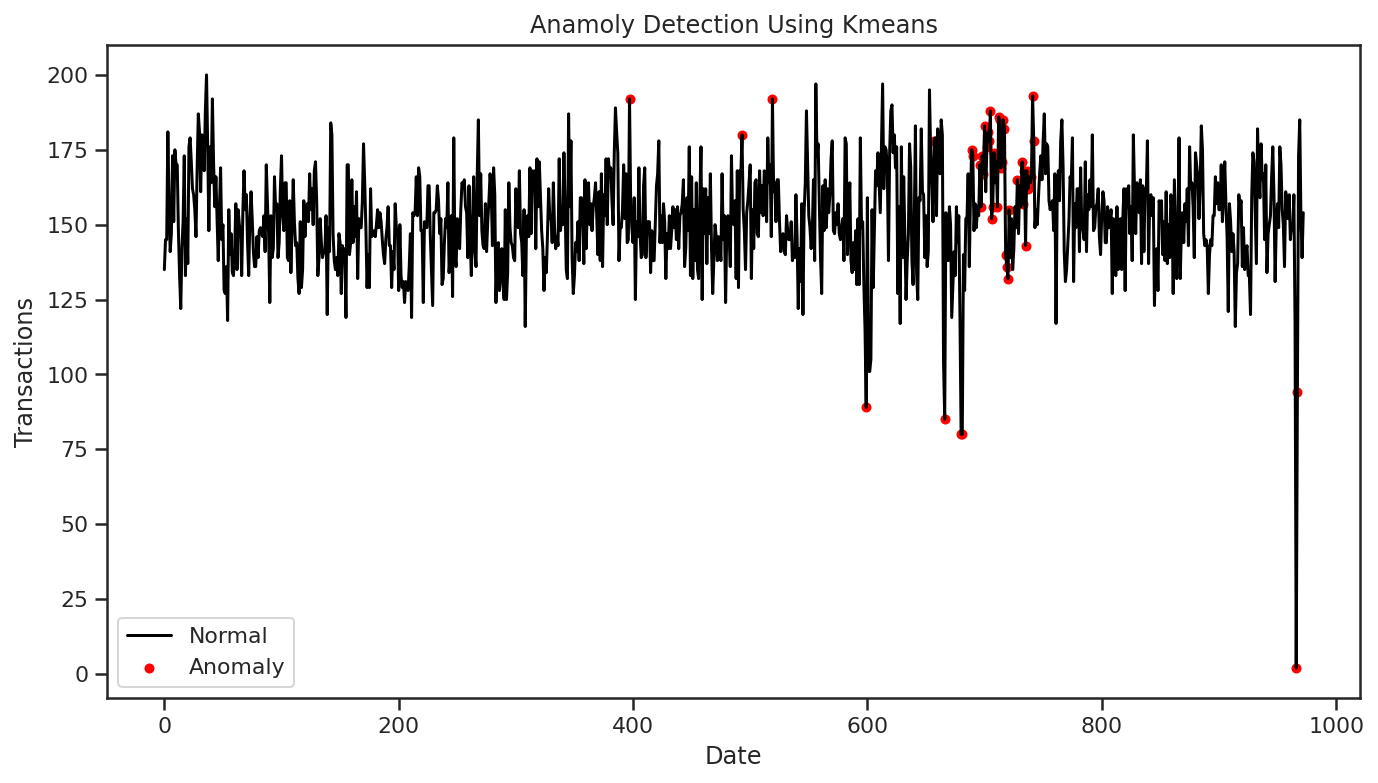

In [36]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_kmeans'] == 1]
ax.plot(result['Transactions'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Transactions'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Kmeans")
plt.xlabel('Date')
plt.ylabel('Transactions')
#plt.savefig('KMeans_anomaly_Transactions.png', dpi=1000)
plt.show();

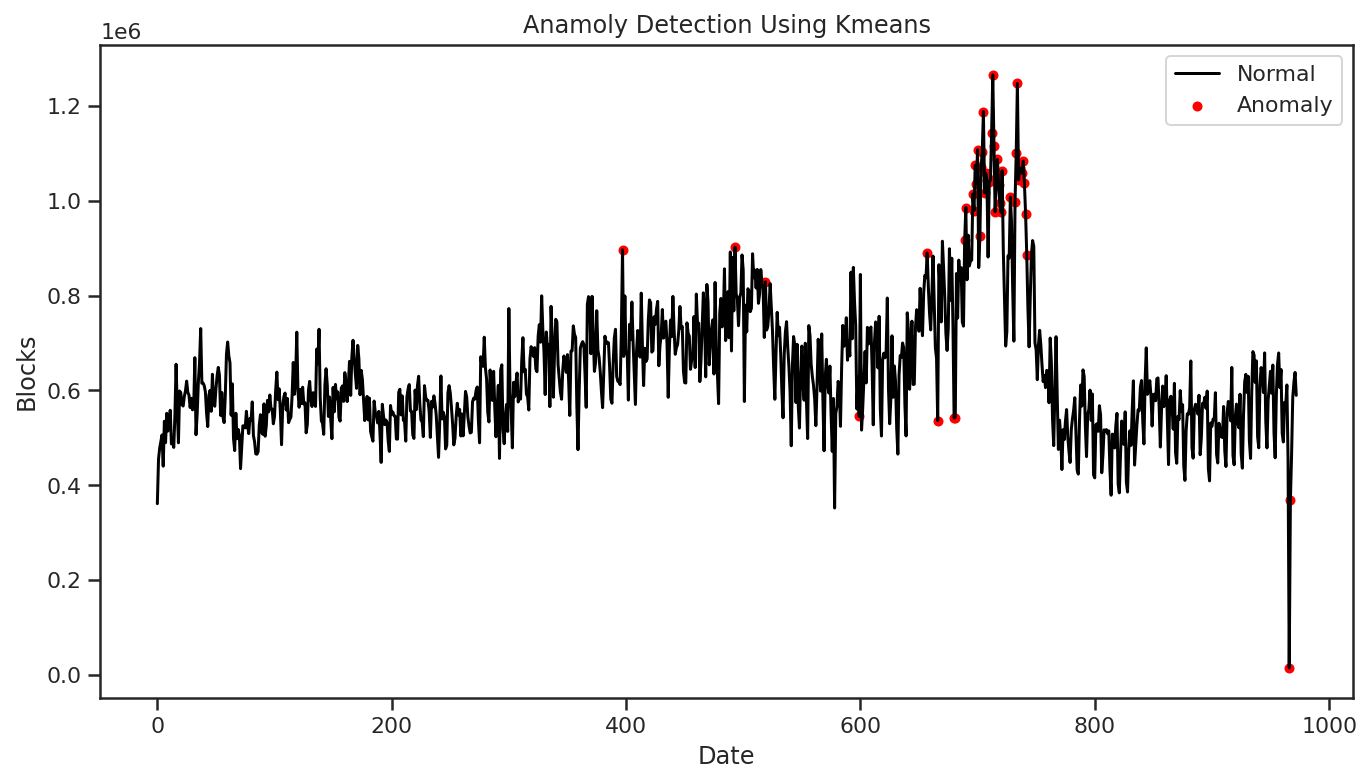

In [37]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_kmeans'] == 1]
ax.plot(result['Blocks'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Blocks'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Kmeans")
plt.xlabel('Date')
plt.ylabel('Blocks')
#plt.savefig('KMeans_anomaly_Blocks.png', dpi=1000)
plt.show();

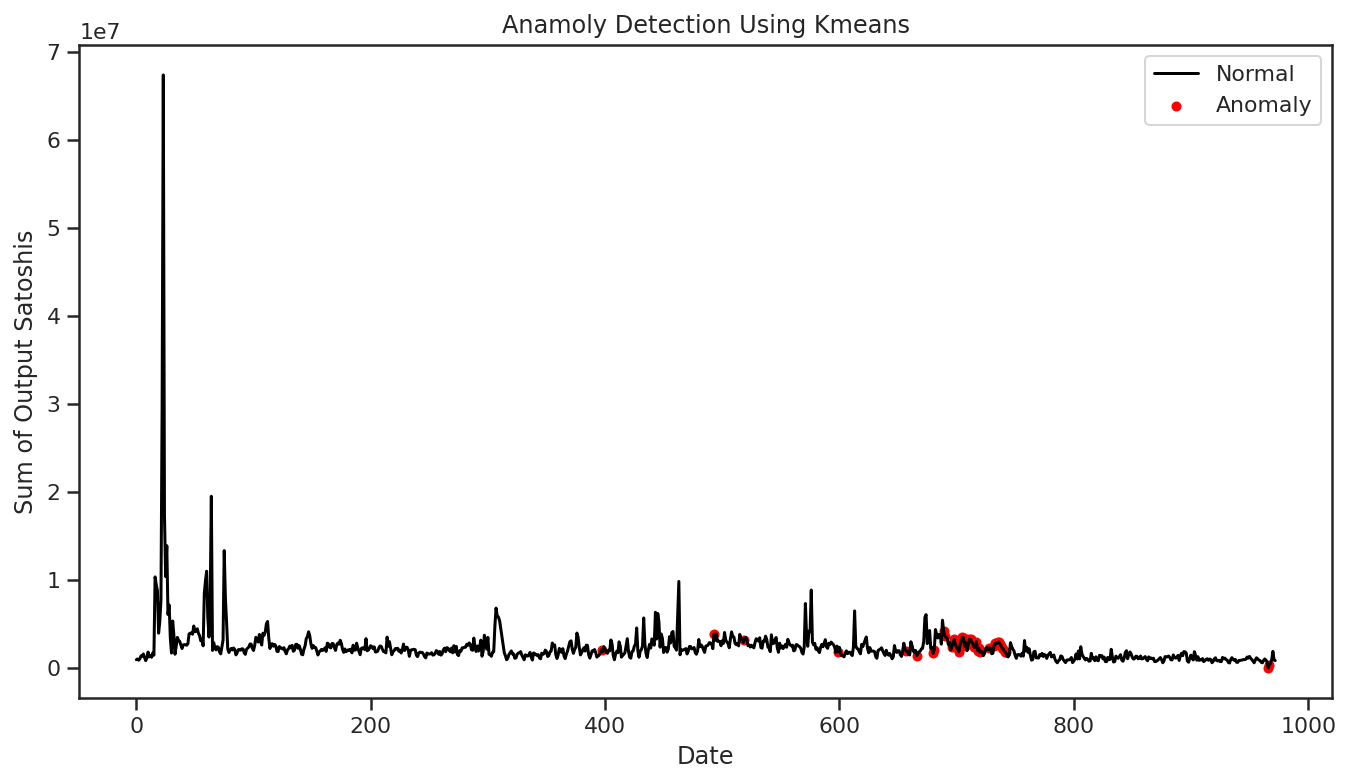

In [38]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_kmeans'] == 1]
ax.plot(result['Output_Satoshis'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Output_Satoshis'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Kmeans")
plt.xlabel('Date')
plt.ylabel('Sum of Output Satoshis')
#plt.savefig('KMeans_anomaly_Output_Satoshis.png', dpi=1000)
plt.show();

In [39]:
# final result dataframe
result.head()

,Date,Transactions,Blocks,Output_Satoshis,anomaly_IsolationForest,anomaly_kmeans
0,2016-01-01,135,361519,9.574813e+05,1,0
1,2016-01-02,145,455120,1.037920e+06,0,0
2,2016-01-03,145,478708,8.985480e+05,0,0
3,2016-01-04,181,492865,1.067068e+06,0,0
4,2016-01-05,157,506371,1.392599e+06,0,0


In [40]:
result

,Date,Transactions,Blocks,Output_Satoshis,anomaly_IsolationForest,anomaly_kmeans
0,2016-01-01,135,361519,9.574813e+05,1,0
1,2016-01-02,145,455120,1.037920e+06,0,0
2,2016-01-03,145,478708,8.985480e+05,0,0
3,2016-01-04,181,492865,1.067068e+06,0,0
4,2016-01-05,157,506371,1.392599e+06,0,0
...,...,...,...,...,...,...
968,2018-08-26,173,463319,5.155083e+05,0,0
969,2018-08-27,185,585010,9.744078e+05,0,0
970,2018-08-28,153,616972,1.898013e+06,0,0
971,2018-08-29,139,638060,9.013310e+05,0,0


In [41]:
# select the cases for final anomaly in which both the algorithms predicted anomaly
final_anomaly = result.query('anomaly_kmeans == 1 & anomaly_IsolationForest == 1')
final_anomaly.head()

,Date,Transactions,Blocks,Output_Satoshis,anomaly_IsolationForest,anomaly_kmeans
397,2017-02-01,192,896356,2.078949e+06,1,1
493,2017-05-08,180,902129,3.877216e+06,1,1
519,2017-06-03,192,828892,3.233909e+06,1,1
666,2017-10-28,85,536785,1.417696e+06,1,1
680,2017-11-11,80,542026,1.664880e+06,1,1


In [42]:
# Select the cases in which either of the two algorithms predicted anomaly
possible_anomaly = result.query('anomaly_kmeans == 1 | anomaly_IsolationForest == 1')
possible_anomaly.head()

,Date,Transactions,Blocks,Output_Satoshis,anomaly_IsolationForest,anomaly_kmeans
0,2016-01-01,135,361519,9.574813e+05,1,0
16,2016-01-17,151,655229,1.035818e+07,1,0
17,2016-01-18,173,561828,9.462153e+06,1,0
18,2016-01-19,133,489778,8.804629e+06,1,0
21,2016-01-22,176,570236,7.717680e+06,1,0


In [43]:
# Select the cases where no algorithm predicted anomaly
no_anomaly = result.query('anomaly_kmeans == 0 & anomaly_IsolationForest == 0')
no_anomaly.head()

,Date,Transactions,Blocks,Output_Satoshis,anomaly_IsolationForest,anomaly_kmeans
1,2016-01-02,145,455120,1.037920e+06,0,0
2,2016-01-03,145,478708,8.985480e+05,0,0
3,2016-01-04,181,492865,1.067068e+06,0,0
4,2016-01-05,157,506371,1.392599e+06,0,0
5,2016-01-06,141,440544,1.337497e+06,0,0


In [44]:
total_anomaly = len(final_anomaly)+len(possible_anomaly)
percent_total_anomaly = total_anomaly*100/len(result)
print('Total records:',len(result))
print('Number of final anomaly:', len(final_anomaly))
print('Number of possible anomaly:', len(possible_anomaly))
print('Total anomaly:', total_anomaly)
print('Percentage of total anomaly in the data: %0.2f' % percent_total_anomaly)

Total records: 973
Number of final anomaly: 25
Number of possible anomaly: 72
Total anomaly: 97
Percentage of total anomaly in the data: 9.97


# Conclusion

Hence, we have determined 76 possible anomalies in the last three years (i.e., 10 percent anomaly) of Google BigQuery Bitcoin Blockchain dataset. We have utilized two popular anomaly detection methods: Isolation Forest and K-Means. The notable fact obtained from the results is that both anomaly detection methods predicts 38 anomaly cases, which is reasonably consistent. We can further explore the anomaly detection in blockchain systems by utilizing more data or including other features. Lastly, anomaly detection tools can be effectively used to make the blockchain systems even stronger and safer by automatically recognizing and filtering out anomalous activities.